# Tensorflow


[TensorFlow Federated](https://www.tensorflow.org/federated/)(TFF) is an open source framework for experimenting with machine learning and other computations on decentralized data.

Here is video introducing federated learning for tensorflow from TF 2.0 Dev Summit.

[![IFederated Learning](https://img.youtube.com/vi/1YbPmkChcbo/0.jpg)](https://www.youtube.com/watch?v=1YbPmkChcbo)


Here is the accompanying blog by [Tensorflow Team](https://medium.com/tensorflow/introducing-tensorflow-federated-a4147aa20041) and [Documentation](https://www.tensorflow.org/federated/federated_learning).

Blog: [Federated Learning and Privacy]()

Code Adapted from: [Link](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification)

Must visit Tensorflow [Federated Tutorials](https://www.tensorflow.org/federated/tutorials) on Image Classification, Text Generation and implementing custom Federated Averaging Algorithm.

In [1]:
! pip install -q tensorflow_federated

    100% |████████████████████████████████| 194kB 3.6MB/s 
    100% |████████████████████████████████| 4.8MB 6.7MB/s 
pymc3 3.6 has requirement h5py>=2.7.0, but you'll have h5py 2.6.0 which is incompatible.


In [2]:
from __future__ import absolute_import, division, print_function


import collections
from six.moves import range
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow_federated import python as tff
import matplotlib.pyplot as plt
%matplotlib inline

nest = tf.contrib.framework.nest

np.random.seed(0)

tf.compat.v1.enable_v2_behavior()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## EMNIST Dataset

To illustrate the use of FL and TFF, let’s start with one of the most famous image datasets: MNIST. The [original NIST](https://www.nist.gov/srd/nist-special-database-19) dataset, from which MNIST was created, contains images of 810,000 handwritten digits, collected from 3,600 volunteers — and our task is to build an ML model that will recognize the digits from data preprocessed by [Leaf](https://github.com/TalwalkarLab/leaf). The traditional way we’d go about it is to apply an ML algorithm to the entire dataset at once. But what if we couldn’t combine all that data together — for example, because the volunteers did not agree to uploading their raw data to a central server?


#### MNIST

Creating a custom federated training data from MNIST dataset with 60 clients (as 60,000 examples of MNIST).

```python
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100

def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x': np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                      dtype=np.float32),
        'y': np.array([source[1][i] for i in batch_samples], dtype=np.int32)})
  return output_sequence

federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

```



In [3]:
# load emnist dataset
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 3s 0us/step


In [4]:
# number of clients
len(emnist_train.client_ids)

3383

In [5]:
# output types and shapes
emnist_train.output_types, emnist_train.output_shapes

(OrderedDict([('label', tf.int32), ('pixels', tf.float32)]),
 OrderedDict([('label', TensorShape([])), ('pixels', TensorShape([28, 28]))]))

### Sample Example from Dataset

In [6]:
#get one example from client:0
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

Instructions for updating:
Colocations handled automatically by placer.


5

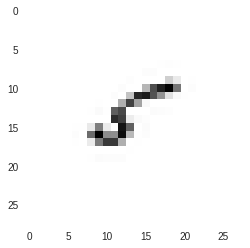

In [7]:
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
plt.show()

### Preprocess data and create Keras model


A simple helper function that will construct a list of datasets from the given set of users as an input to a round of training or evaluation.

```python
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

```


Typically then, when running simulations, we would simply sample a random subset of the clients to be involved in each round of training, generally different in each round.

You can find out by studying the paper on the [Federated Averaging algorithm](), achieving convergence in a system with randomly sampled subsets of clients in each round can take a while, and it would be impractical to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and reuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data). We leave it as an exercise for the reader to modify this tutorial to simulate random sampling - it is fairly easy to do (once you do, keep in mind that getting the model to converge may take a while).

In [0]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500


def preprocess(dataset):

  def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['pixels'], [-1])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)


In [9]:
#print sample batch
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = nest.map_structure(lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

print (sample_batch)

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)), ('y', array([[6],
       [7],
       [1],
       [0],
       [5],
       [6],
       [5],
       [0],
       [7],
       [9],
       [0],
       [2],
       [6],
       [0],
       [4],
       [0],
       [3],
       [2],
       [3],
       [8]], dtype=int32))])


In [0]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

In [11]:
# sample data for only 3 clients (fixed for now) for each round

NUM_CLIENTS = 3

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print (len(federated_train_data), federated_train_data[0])

3 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [0]:
# create keras model

def create_compiled_keras_model():
  # dense layer
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(784,))])
  
  def loss_fn(y_true, y_pred):
    # categorical cross entropy
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))
 
  model.compile(loss=loss_fn,
                optimizer=gradient_descent.SGD(learning_rate=0.02),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [0]:
# create a tff learning model from compiled keras model
def model_fn():
  keras_model = create_compiled_keras_model()
  return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [0]:
# construct a Federated Averaging algorithm by invoking the helper function 
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

What just happened? TFF has constructed a pair of federated computations and packaged them into a tff.utils.IterativeProcess in which these computations are available as a pair of properties `initialize` and `next`.

In a nutshell, federated computations are programs in TFF's internal language that can express various federated algorithms

In [15]:
# first of pair initialize computation returns result 
# the representation of the state of the Federated Averaging process on the server
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<dense/kernel=float32[784,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>>@SERVER)'

In [0]:
# initialize computation to construct the server state.

state = iterative_process.initialize()

In [17]:
# second of pair next  epresents a single round of Federated Averaging, 
# which consists of pushing the server state (including the model parameters) to the clients, 
# on-device training on their local data, collecting and averaging model updates, 
# and producing a new updated model at the server.
# SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS

for round_num in range(1, 10):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

  

round  1, metrics=<sparse_categorical_accuracy=0.14545454,loss=3.1084356>
round  2, metrics=<sparse_categorical_accuracy=0.17054546,loss=2.8489537>
round  3, metrics=<sparse_categorical_accuracy=0.20581818,loss=2.5649288>
round  4, metrics=<sparse_categorical_accuracy=0.24654545,loss=2.4538224>
round  5, metrics=<sparse_categorical_accuracy=0.2738182,loss=2.292969>
round  6, metrics=<sparse_categorical_accuracy=0.3458182,loss=1.9596573>
round  7, metrics=<sparse_categorical_accuracy=0.36618182,loss=1.915014>
round  8, metrics=<sparse_categorical_accuracy=0.45963636,loss=1.618384>
round  9, metrics=<sparse_categorical_accuracy=0.472,loss=1.607465>


Training loss seems to be converging.